# California Housing Prediction

In [1]:
from sklearn.datasets import fetch_california_housing
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate

In [2]:
housing = fetch_california_housing() #import dataset

In [3]:
#check dataset structure 
print(housing.data.shape, housing.target.shape)
print(housing.feature_names)

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


<Axes: ylabel='Count'>

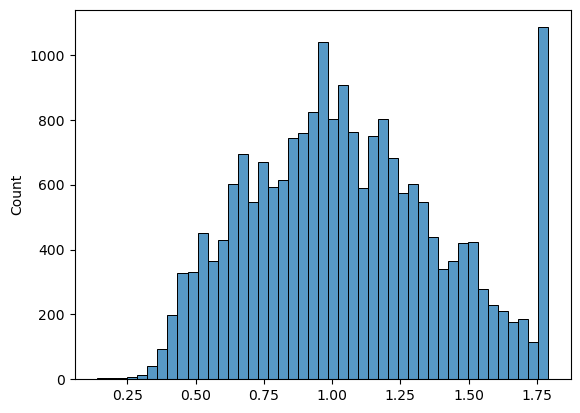

In [4]:
# view data set in log transform 
target_log1p = np.log1p(housing["target"])
sns.histplot(target_log1p)

In [5]:
n = housing.data.shape[0] #total records

In [6]:
#read in dataset with target as DataFrame
housing_df = pd.DataFrame(np.array(housing.data), columns=housing.feature_names)

housing_df["MedHouseVal"] = np.array(housing.target)
# housing_df["MedHouseVal"] = np.log1p(np.array(housing.target))
housing_df.drop(columns=["Latitude", "Longitude"], inplace=True)
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


In [7]:
# random index generator
np.random.seed(12)
idx = list(housing_df.index)
np.random.shuffle(idx)
idx[:6]

[6906, 767, 10555, 17456, 20617, 7729]

In [8]:
#train, val and test record size
train_size = int(n * 0.6)
val_size = int(n * 0.2)
test_size = n - (train_size + val_size)
train_size + val_size + test_size

20640

In [9]:
#extract train, val and test dataframe 
train_df = housing_df.iloc[idx[:train_size]]
val_df = housing_df.iloc[idx[train_size:train_size+val_size]]
test_df = housing_df.iloc[idx[train_size+val_size:]]

train_df.shape, val_df.shape, test_df.shape

((12384, 7), (4128, 7), (4128, 7))

In [10]:
# function to prepare X for training 
def prepare_X(df):
    base_col = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population','AveOccup']

    return df[base_col].values

In [11]:
# calculate Root Mean Square Error
def rmse(y, y_pred):
    error = y - y_pred
    squared_error = error ** 2
    mse = squared_error.mean()
    return np.sqrt(mse)

In [12]:
#train the model and return bias and weight 
def train_linear_regression_reg(X, y, r=0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0]) #regularized
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
#extract needed training record and target 
X_train = prepare_X(train_df)
y_train = train_df["MedHouseVal"].values
y_train

array([2.114, 1.952, 2.418, ..., 1.783, 1.458, 1.872])

In [14]:
# baseline model 
w0, w = train_linear_regression_reg(X_train, y_train)
w0, w

(-0.22224339825489509,
 array([ 5.38013232e-01,  1.60362763e-02, -2.18920478e-01,  9.29102884e-01,
         2.26093894e-05, -3.87572740e-02]))

In [15]:
#prepare validation features
X_val = prepare_X(val_df)
y_val = val_df["MedHouseVal"].values

In [16]:
# run prediction on multiple r
scores = []
for r in [-1, 0, 0.01, 0.001, 0.0001, 10, 100, 100]:
    
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)
    scores.append([r, score, w0])
print(tabulate(scores, floatfmt=".4f", headers=["R", "rmse", "w0"]))

       R    rmse       w0
--------  ------  -------
 -1.0000  0.8887  -0.2236
  0.0000  0.8888  -0.2223
  0.0100  0.8888  -0.2222
  0.0010  0.8888  -0.2223
  0.0001  0.8888  -0.2223
 10.0000  0.8898  -0.2089
100.0000  0.8966  -0.1229
100.0000  0.8966  -0.1229


In [17]:
# retrain with best r
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
w0, w

(-0.22225583000815344,
 array([ 5.38015636e-01,  1.60362936e-02, -2.18924659e-01,  9.29125243e-01,
         2.26095615e-05, -3.87571424e-02]))

In [18]:
# get the full training dataset
X_train_full = prepare_X(pd.concat([train_df, val_df]))
y_train_full = np.concatenate([y_train, y_val])

In [19]:
# retrain model using full record and best r
w0, w = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)
w0, w

(-0.3488402922188878,
 array([ 5.43966277e-01,  1.62060897e-02, -2.27340136e-01,  9.83310442e-01,
         1.56309882e-05, -6.04699873e-03]))

In [20]:
# prepare testing dataset
X_test = prepare_X(test_df)
y_test = test_df["MedHouseVal"].values

In [21]:
# make prediction 
y_pred = w0 + X_test.dot(w)

In [22]:
# estimate the rmse
rmse(y_test, y_pred)

0.7961320777598965